In [237]:
!git clone https://github.com/qubvel/classification_models.git


fatal: destination path 'classification_models' already exists and is not an empty directory.


In [0]:
!ls

classification_models  sample_data


In [0]:
import keras
from classification_models.classification_models.resnet import ResNet18, preprocess_input
from keras.preprocessing import image
from keras.datasets import cifar10
from keras.preprocessing.image import ImageDataGenerator
import pandas as pd
import cv2

In [0]:
(x_train, y_train), (x_test, y_test) = cifar10.load_data()

170500096/170498071 [==============================] - 2s 0us/step


In [0]:
base_model = ResNet18(input_shape=(32,32,3), weights='imagenet', include_top=False)

W0701 15:04:39.310812 140505406285696 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:517: The name tf.placeholder is deprecated. Please use tf.compat.v1.placeholder instead.

W0701 15:04:39.712505 140505406285696 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:245: The name tf.get_default_graph is deprecated. Please use tf.compat.v1.get_default_graph instead.

W0701 15:04:39.713492 140505406285696 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:174: The name tf.get_default_session is deprecated. Please use tf.compat.v1.get_default_session instead.

W0701 15:04:39.718736 140505406285696 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:181: The name tf.ConfigProto is deprecated. Please use tf.compat.v1.ConfigProto instead.

W0701 15:04:39.719826 140505

44924928/44920640 [==============================] - 1s 0us/step


In [0]:
n_classes = 10

In [0]:
x = keras.layers.GlobalAveragePooling2D()(base_model.output)
output = keras.layers.Dense(n_classes, activation='softmax')(x)
model = keras.models.Model(inputs=[base_model.input], outputs=[output])

In [0]:
X = preprocess_input(x_train)
X_val = preprocess_input(x_test)

In [0]:
import numpy as np
# random cutouts

def get_random_eraser(p=0.5, s_l=0.02, s_h=0.4, r_1=0.3, r_2=1/0.3, v_l=0, v_h=255, pixel_level=False):
    def eraser(input_img):
        img_h, img_w, img_c = input_img.shape
        p_1 = np.random.rand()

        if p_1 > p:
            return input_img

        while True:
            s = np.random.uniform(s_l, s_h) * img_h * img_w
            r = np.random.uniform(r_1, r_2)
            w = int(np.sqrt(s / r))
            h = int(np.sqrt(s * r))
            left = np.random.randint(0, img_w)
            top = np.random.randint(0, img_h)

            if left + w <= img_w and top + h <= img_h:
                break

        if pixel_level:
            c = np.random.uniform(v_l, v_h, (h, w, img_c))
        else:
            c = np.random.uniform(v_l, v_h)

        input_img[top:top + h, left:left + w, :] = c

        return input_img

    return eraser


In [0]:
model.compile(optimizer='SGD', loss='categorical_crossentropy', metrics=['accuracy'])

W0701 15:05:14.131077 140505406285696 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/optimizers.py:790: The name tf.train.Optimizer is deprecated. Please use tf.compat.v1.train.Optimizer instead.



# Model training

In [0]:
datagen = ImageDataGenerator(
    width_shift_range=0.1,
    height_shift_range=0.1,
    horizontal_flip=True,
    preprocessing_function=get_random_eraser())

In [0]:
train_gen=datagen.flow(X,y_train,batch_size=128)

In [0]:
model.fit_generator(train_gen,
                    epochs=20,
                    steps_per_epoch=1000,
                    verbose=1,
                    validation_data=(X_val, y_val))

Epoch 1/20
1000/1000 [==============================] - 65s 65ms/step - loss: 0.8341 - acc: 0.7073 - val_loss: 0.6887 - val_acc: 0.7609
Epoch 2/20
1000/1000 [==============================] - 63s 63ms/step - loss: 0.7348 - acc: 0.7409 - val_loss: 0.6175 - val_acc: 0.7842
Epoch 3/20
1000/1000 [==============================] - 64s 64ms/step - loss: 0.6765 - acc: 0.7604 - val_loss: 0.5923 - val_acc: 0.7919
Epoch 4/20
1000/1000 [==============================] - 64s 64ms/step - loss: 0.6357 - acc: 0.7768 - val_loss: 0.5416 - val_acc: 0.8133
Epoch 5/20
1000/1000 [==============================] - 64s 64ms/step - loss: 0.6026 - acc: 0.7878 - val_loss: 0.5330 - val_acc: 0.8131
Epoch 6/20
1000/1000 [==============================] - 65s 65ms/step - loss: 0.5722 - acc: 0.7980 - val_loss: 0.5191 - val_acc: 0.8210
Epoch 7/20
1000/1000 [==============================] - 65s 65ms/step - loss: 0.5468 - acc: 0.8069 - val_loss: 0.5101 - val_acc: 0.8207
Epoch 8/20
1000/1000 [==========================

# Finding misclassified images

In [0]:
preds = model.predict(X_val)

In [0]:
predictions = []
for i in range(len(preds)):
    predictions.append(np.argmax(preds[i]))

In [0]:
y_test[:,0]

array([3, 8, 8, ..., 5, 1, 7])

In [0]:
df = pd.DataFrame(columns=['prediction','true'])

In [0]:
df['prediction'] = predictions
df['true'] = y_test[:,0]

In [0]:
mismatches = list(df[df['prediction']!=df['true']].index)

In [0]:
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
data (InputLayer)               (None, 32, 32, 3)    0                                            
__________________________________________________________________________________________________
bn_data (BatchNormalization)    (None, 32, 32, 3)    9           data[0][0]                       
__________________________________________________________________________________________________
zero_padding2d_1 (ZeroPadding2D (None, 38, 38, 3)    0           bn_data[0][0]                    
__________________________________________________________________________________________________
conv0 (Conv2D)                  (None, 16, 16, 64)   9408        zero_padding2d_1[0][0]           
__________________________________________________________________________________________________
bn0 (Batch

# Sample output

In [0]:
import matplotlib.pyplot as plt
import keras.backend as K

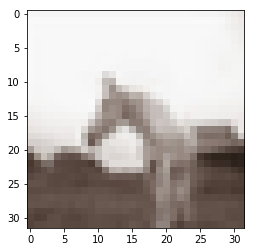

In [0]:
#fig = plt.figure(figsize=(10,5))
plt.imshow(X_val[87])

In [0]:
class_output = model.output[:, predictions[87]]

In [0]:
last_conv_layer = model.get_layer("stage1_unit1_conv2") # using initial convolution layers

In [0]:
x = image.img_to_array(X_val[87])
x = np.expand_dims(x, axis=0)
x = preprocess_input(x)

In [0]:
grads = K.gradients(class_output, last_conv_layer.output)[0]
pooled_grads = K.mean(grads, axis=(0, 1, 2))
iterate = K.function([model.input], [pooled_grads, last_conv_layer.output[0]])
pooled_grads_value, conv_layer_output_value = iterate([x])
for i in range(64):
    conv_layer_output_value[:, :, i] *= pooled_grads_value[i]

In [0]:
heatmap = np.mean(conv_layer_output_value, axis=-1)
heatmap = np.maximum(heatmap, 0)
heatmap /= np.max(heatmap)

In [0]:
heatmap = cv2.resize(heatmap, (X_val[13].shape[1], X_val[13].shape[0]))
heatmap = np.uint8(255 * heatmap)
heatmap = cv2.applyColorMap(heatmap, cv2.COLORMAP_JET)
superimposed_img = cv2.addWeighted(X_val[87], 0.6, heatmap, 0.4, 0)

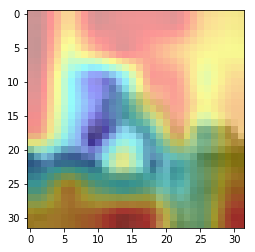

In [0]:
plt.imshow(superimposed_img)

# Misclassified images

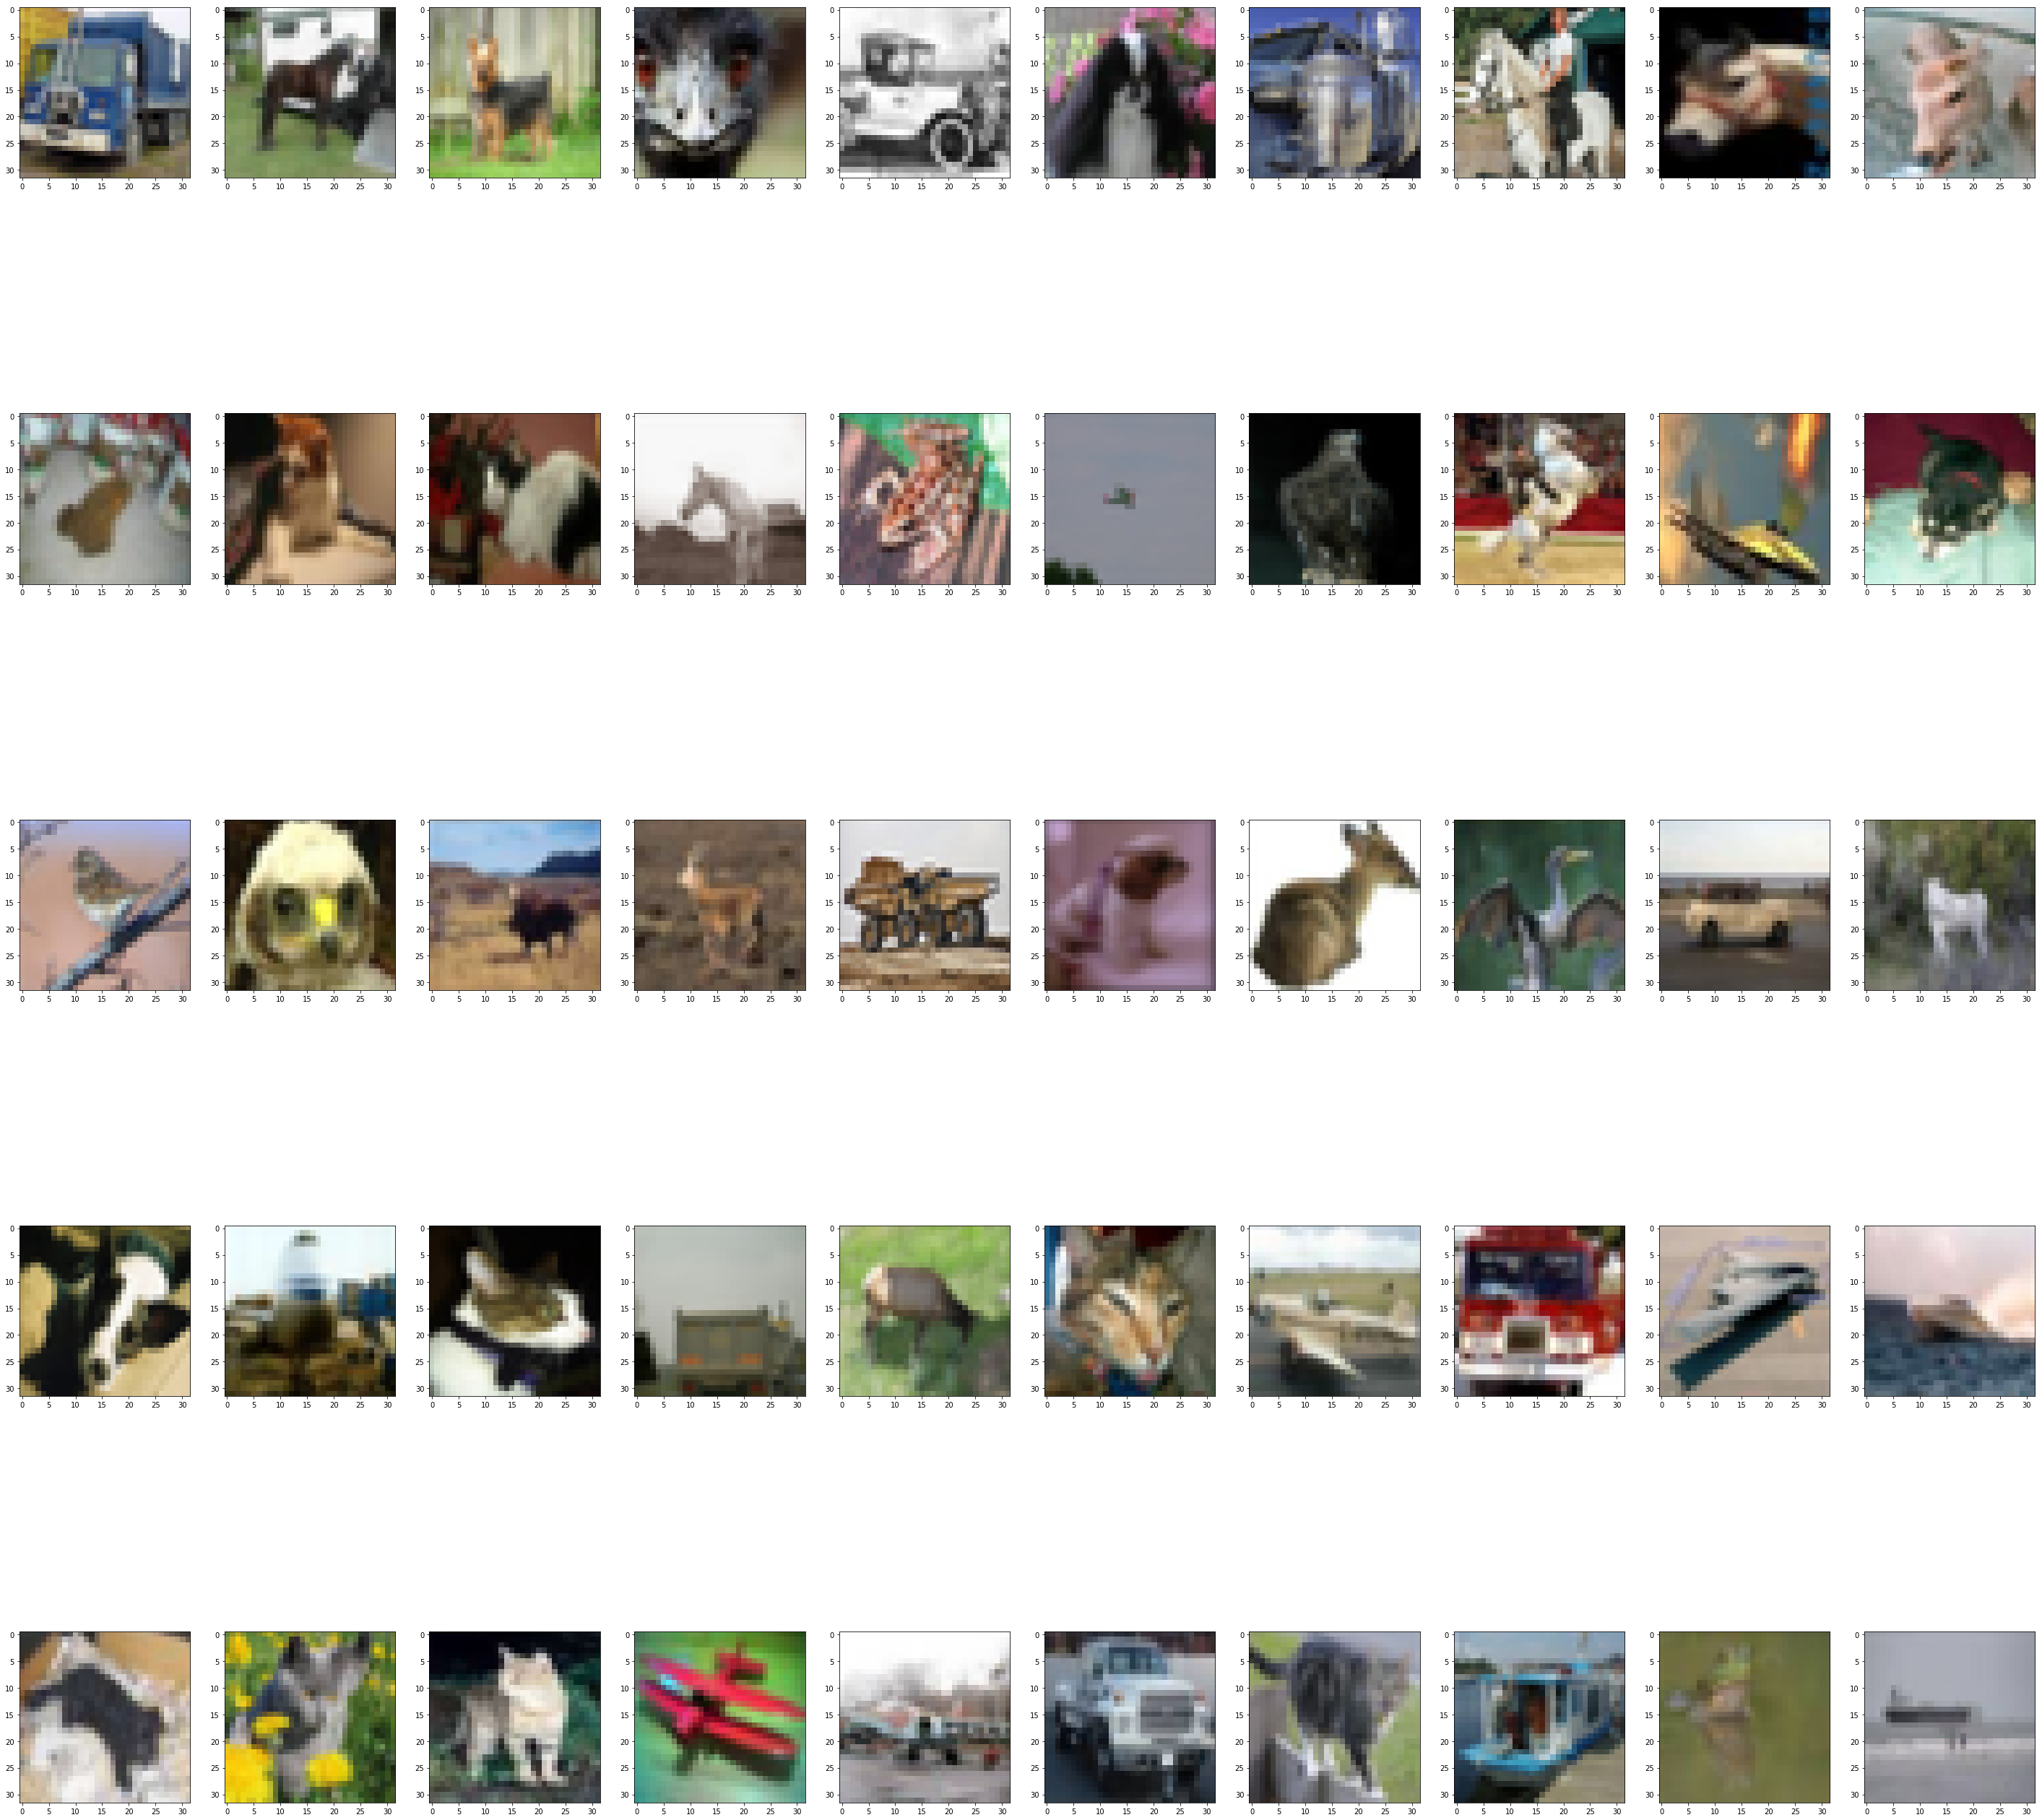

In [249]:
w=32
h=32
fig=plt.figure(figsize=(50, 50))
columns = 10
rows = 5
for i in range(1, columns*rows +1):
  img = X_val[mismatches[i-1]]
  fig.add_subplot(rows, columns, i)
  plt.imshow(img)
plt.show()

# Corresponding heatmaps for images

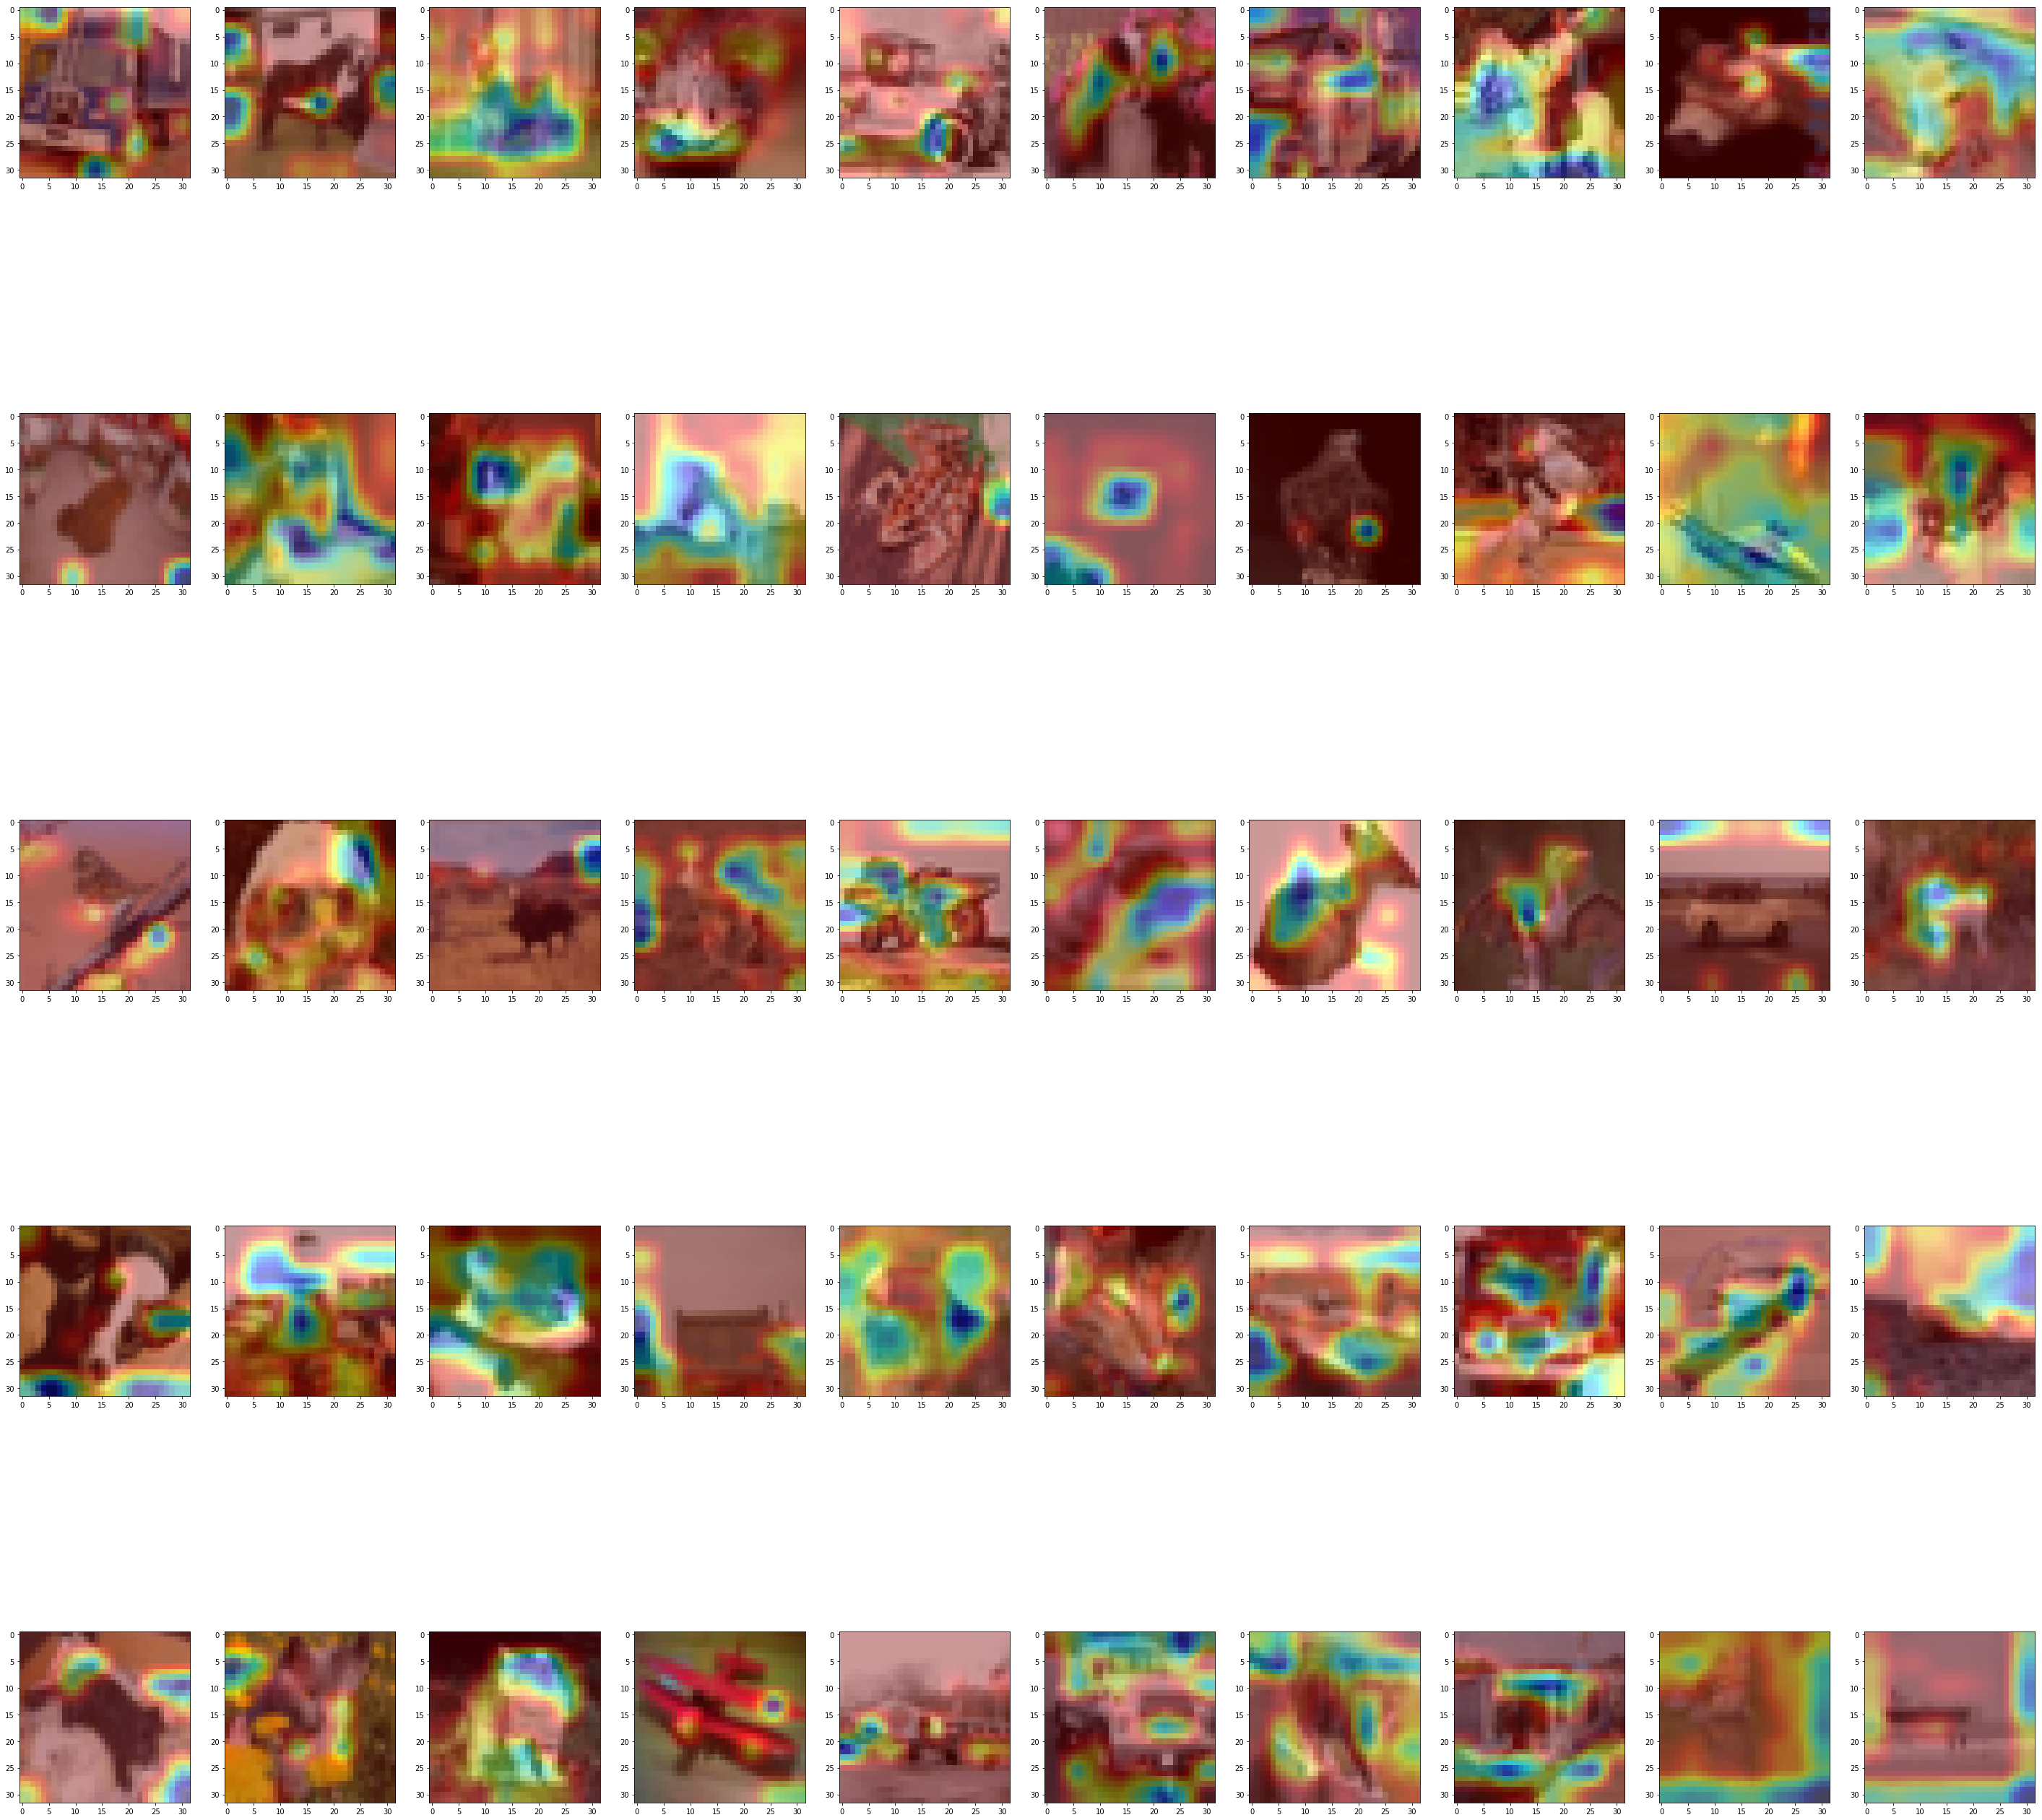

In [252]:
w=32
h=32
fig=plt.figure(figsize=(50, 50))
columns = 10
rows = 5
for i in range(1, columns*rows +1):
  class_output = model.output[:, predictions[mismatches[i-1]]]
  last_conv_layer = model.get_layer("stage1_unit1_conv2")
  
  x = image.img_to_array(X_val[mismatches[i-1]])
  x = np.expand_dims(x, axis=0)
  x = preprocess_input(x)
  
  grads = K.gradients(class_output, last_conv_layer.output)[0]
  pooled_grads = K.mean(grads, axis=(0, 1, 2))
  iterate = K.function([model.input], [pooled_grads, last_conv_layer.output[0]])
  pooled_grads_value, conv_layer_output_value = iterate([x])
  for j in range(64):
    conv_layer_output_value[:, :, j] *= pooled_grads_value[j]
      
  heatmap = np.mean(conv_layer_output_value, axis=-1)
  heatmap = np.maximum(heatmap, 0)
  heatmap /= np.max(heatmap)
  
  heatmap = cv2.resize(heatmap, (X_val[mismatches[i-1]].shape[1], X_val[mismatches[i-1]].shape[0]))
  heatmap = np.uint8(255 * heatmap)
  heatmap = cv2.applyColorMap(heatmap, cv2.COLORMAP_JET)
  superimposed_img = cv2.addWeighted(X_val[mismatches[i-1]], 0.6, heatmap, 0.4, 0)
  fig.add_subplot(rows, columns, i)
  plt.imshow(superimposed_img)
plt.show()